Python and SQL program, licensed under the Apache License, Version 2.0<br>
http://www.apache.org/licenses/LICENSE-2.0

# 3D representation of the building

In the first part of the analysis, we construct a 3D representation of the apartment building.

In [29]:
# Using the magic command "%matplotlib notebook" to make interactive plots within Jupyter Notebook
# Importing the numpy library (for arrays operations)
# Importing the matplotlib.pyplot interface (for MATLAB-like plots)

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [30]:
# Setting the range of coordinates indices x, y, z for the 3D representation

x, y, z = np.indices((12, 26, 6))

In [31]:
# Setting the building volumes and colors

ground = (x < 12) & (y < 26) & (z < 1)
floors = (x < 12) & (y < 26) & (1 <= z) & (z < 6)
building = ground | floors
    
building_color = np.empty(building.shape, dtype=object)
building_color[ground] = 'grey'
building_color[floors] = 'white'

In [32]:
# Setting the 4th floor apartments volumes and colors

apart_41 = (0 <= x) & (x < 12) & (19 <= y) & (y < 26) & (3 <= z) & (z < 4)
apart_42 = (8 <= x) & (x < 12) & (10 <= y) & (y < 19) & (3 <= z) & (z < 4)
apart_43 = (6 <= x) & (x < 12) & (0 <= y) & (y < 8) & (3 <= z) & (z < 4)
apart_44 = (0 <= x) & (x < 6) & (0 <= y) & (y < 10) & (3 <= z) & (z < 4)
apart_45 = (0 <= x) & (x < 6) & (10 <= y) & (y < 17) & (3 <= z) & (z < 4)
apartments = apart_41 | apart_42 | apart_43 | apart_44 | apart_45

apartments_color = np.empty(building.shape, dtype=object)
apartments_color[apart_41] = 'gold'
apartments_color[apart_42] = 'red'
apartments_color[apart_43] = 'blue'
apartments_color[apart_44] = 'violet'
apartments_color[apart_45] = 'green'

<IPython.core.display.Javascript object>


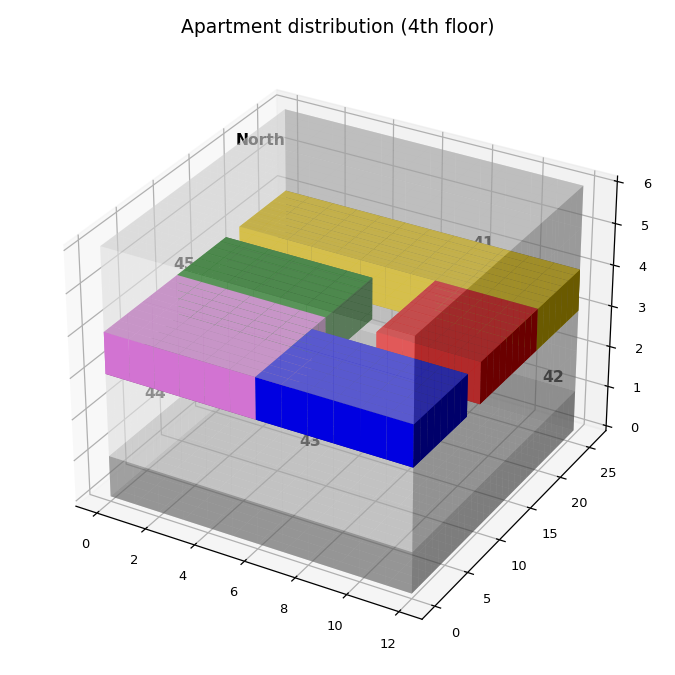

In [33]:
# 3D plot of the apartment building
# Setting parameters, title and annotations of the plot

pl = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
pl.voxels(building, facecolors=building_color, alpha=0.4)
pl.voxels(apartments, facecolors=apartments_color)

plt.title('Apartment distribution (4th floor)')

pl.text(8.5, -3, 3.3, '43', weight='bold')
pl.text(2.5, -3, 3.3, '44', weight='bold')
pl.text(7, 29, 3.3, '41', weight='bold')
pl.text(13.5, 13.5, 3.3, '42', weight='bold')
pl.text(-1.5, 14.5, 3.3, '45', weight='bold')
pl.text(-3, 29, 4.3, 'North', weight='bold')

plt.tight_layout()

# Connection to the MySQL database

In the next part, we set up a connection to the MySQL database containing the data of the building.

In [34]:
# Importing os module (for interacting with the operating system)
# Importing the pandas library (for data analysis)
# Importing create_engine from the sqlalchemy toolkit (standard SQL toolkit in Python)
# Importing load_dotenv from the dotenv module (for setting environment variables)

import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [35]:
# Loading from a hidden .env file the credentials of the MySQL database of the building

load_dotenv()
user = os.getenv('MySQL_USER')
passwd = os.getenv('MySQL_PASSWORD')
host = os.getenv('MySQL_HOST')
port = os.getenv('MySQL_PORT')
db = os.getenv('MySQL_DB')

In [36]:
# Creating a connection (engine) to the MySQL database using the credentials

engine = create_engine('mysql://%s:%s@%s:%s/%s' % (user, passwd, host, port, db))

# Description of the database

The analysis relies on 3 tables from the database, "Apartments", "Power" and "Temperatures", that we now describe.

The Apartments table contains the list of all units of the building (31 apartments + 4 weather stations). The "esmart_id" is the identification number given to each unit by the managing firm eSMART. The column "name" is a more intuitive identification number for the units. For instance, the name "43" corresponds to floor 4, apartment 3.

In [37]:
# Storing an excerpt of the Apartments table in a DataFrame "df_apart"

df_apart = pd.read_sql('SELECT * FROM Apartments', engine)
df_apart.head()

,esmart_id,name
0,1046,11
1,1047,12
2,1048,13
3,1049,14
4,1050,15


The Power table contains data about power consumption for heating of each apartment starting from 2017-10-12. Each row of the table contains the "apartment_id" (= esmart_id), the "module_id" of the module taking the measure, the "date" of the measure and the "value" measured by the module. The module_id can take two values:
- <b>17</b> for electric power measured in Watt [W],
- <b>18</b> for the energy measured in Watt-hour [Wh].

In [38]:
# Storing an excerpt of the Power table in a DataFrame "df_P"

df_P = pd.read_sql('SELECT * FROM Power LIMIT 100', engine)
df_P.head()

,apartment_id,module_id,date,value
0,1026,17,2017-10-12,9242
1,1026,17,2017-10-13,10658
2,1026,17,2017-10-14,11523
3,1026,17,2017-10-15,12394
4,1026,17,2017-10-16,13260


The Temperatures table contains data about temperatures in [°C] of each apartment starting from 2021-03-15. Each row of the table contains the "apartment_id", the "module_id" for the room location of the module taking the measure, the "date" of the measure, the "action" of the module (<b>get</b> for temperature measured in the room and <b>set</b> for temperature set in the room) and the "value" of the temperature.

In [39]:
# Storing an excerpt of the Temperatures table in a DataFrame "df_T"

df_T = pd.read_sql('SELECT * FROM Temperatures LIMIT 100', engine)
df_T.head()

,apartment_id,module_id,date,action,value
0,1026,1,2021-03-15 11:46:46,set,22.0
1,1026,1,2021-03-15 11:56:56,set,22.0
2,1026,1,2021-03-15 12:07:06,set,22.0
3,1026,1,2021-03-15 12:17:17,set,22.0
4,1026,1,2021-03-15 12:27:27,set,22.0


We store in DataFrame "df_dim" the names, areas and volumes of the 31 apartments provided by the architect.

In [40]:
apartments = tuple(df_apart['name'])[:31]

areas = (127.1, 55.8, 78.1, 90.2, 46.9, 113.6, 69.3, 78.1, 90.2, 46.9, 127.1, 55.8, 78.1, 90.2,
         46.9, 113.6, 69.3, 78.1, 90.2, 46.9, 113.6, 69.3, 78.1, 90.2, 46.9, 82.5, 70.2, 120.6,
         85.5, 90.2, 46.9)

volumes = (330.46, 145.08, 203.06, 234.52, 121.94, 295.36, 180.18, 203.06, 234.52, 121.94, 330.46,
           145.08, 203.06, 234.52, 121.94, 295.36, 180.18, 203.06, 234.52, 121.94, 295.36, 180.18,
           203.06, 234.52, 121.94, 231, 203.58, 349.74, 247.95, 261.58, 136.01)

df_dim = pd.DataFrame({'apartment': apartments, 'area [m\u00b2]': areas, 'volume [m\u00b3]': volumes})
df_dim.head()

,apartment,area [m²],volume [m³]
0,11,127.1,330.46
1,12,55.8,145.08
2,13,78.1,203.06
3,14,90.2,234.52
4,15,46.9,121.94


# Energy consumption

In this part of the analysis, we retrieve and plot with a pie chart and a bar chart the energy consumption for heating of each apartment over a period of time between initial date "start" and final date "end".

In [41]:
# Setting start date and end date for the DataFrame of energy consumption

start = '"2022-02-07"'
end = '"2022-04-19"'

# Storing, for each apartment, the first energy measure after the start date into a DataFrame "df_start"

df_start = pd.read_sql('SELECT Apartments.name AS apartment, Power.date AS \'start date\', \
                   Power.value AS \'start energy [Wh]\' FROM Power INNER JOIN Apartments \
                   ON Power.apartment_id=Apartments.esmart_id WHERE Power.module_id=18 AND Power.date>=%s \
                   GROUP BY Apartments.name' % start, engine)

# Storing, for each apartment, the last energy measure before the end date into a DataFrame "df_end"

df_end = pd.read_sql('SELECT Apartments.name AS apartment, Power.date AS \'end date\', \
                   Power.value AS \'end energy [Wh]\' FROM Power INNER JOIN Apartments \
                   ON Power.apartment_id=Apartments.esmart_id WHERE Power.module_id=18 AND Power.date<=%s \
                   ORDER BY Power.date DESC LIMIT 31' % end, engine)

# Merging "df_start" and "df_end" into a DataFrame "df_E", using "apartment" as key
# There are missing measures; for instance the first measure for apartment O2 is at date 2018-10-10

df_E = pd.merge(df_start, df_end, how='left', on='apartment')

# Storing in "df_E" the energy consumption and the energy consumption per cubic metre
# Dividing the values by 1000 to obtain energies in [kWh]

df_E['\u0394E [kWh]'] = [(df_E['end energy [Wh]'][i]-df_E['start energy [Wh]'][i])/1000 for i in range(len(df_E))]
df_E['\u0394E per m\u00b3 [kWh/m\u00b3]'] = [round(df_E['\u0394E [kWh]'][i]/volumes[i], 1) for i in range(len(df_E))]

df_E.head()

,apartment,start date,start energy [Wh],end date,end energy [Wh],ΔE [kWh],ΔE per m³ [kWh/m³]
0,11,2022-02-07,10657000,2022-04-18 23:52:50,10770000,113.0,0.3
1,12,2022-02-07,9553000,2022-04-18 23:54:04,10027000,474.0,3.3
2,13,2022-02-07,11962000,2022-04-18 23:53:35,12521000,559.0,2.8
3,14,2022-02-07,12567000,2022-04-18 23:52:31,13452000,885.0,3.8
4,15,2022-02-07,11376000,2022-04-18 23:58:28,12099000,723.0,5.9


The data of "df_E" is used to plot a pie chart and a bar chart of the energy consumption for heating of each apartment.

<IPython.core.display.Javascript object>


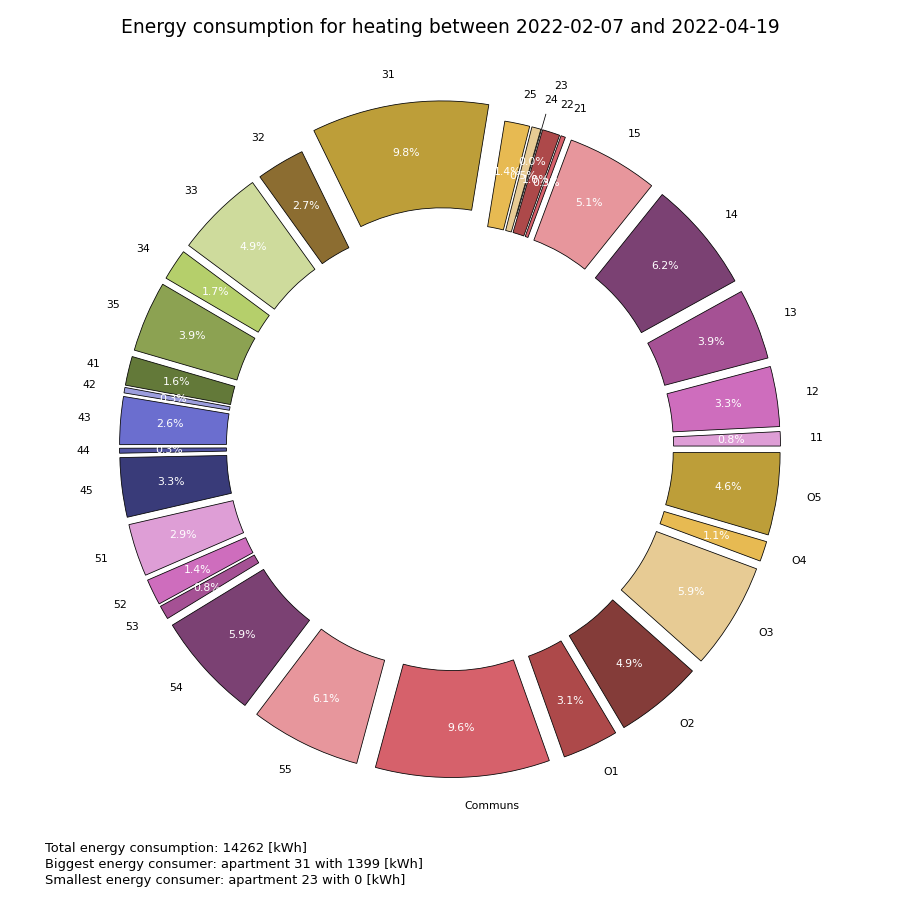

In [42]:
# Storing in variable "data_E" the list of energy consumptions
# Storing in variables "i_max" and "i_min" the indices of apartments having maximum/minimum energy consumption

data_E = df_E['\u0394E [kWh]'].tolist()
i_max = df_E['\u0394E [kWh]'].idxmax()
i_min = df_E['\u0394E [kWh]'].idxmin()

# Checking if there is energy consumption during the time period before proceeding with the plot

if max(data_E)>0:

    # Storing in "scales" the list of scales of the pie chart wedges
    # Storing in "wedges" the dictionary of properties of the pie chart wedges
    # Storing in "colors" the list of colors of the pie chart wedges
    # See https://matplotlib.org/stable/tutorials/colors/colormaps.html for details
    
    scales = [0.17 if i in {i_max, i_min} else 0.12 for i in range(len(data_E))]
    wedges = {'width':0.33, 'edgecolor':'k', 'lw':0.5}
    colors = plt.colormaps['tab20b_r'](range(20))

    # Parameters, title and annotations of the pie chart plot

    _, EC = plt.subplots(figsize=(8, 8))
    _, _, pcts = EC.pie(data_E, labels=apartments, explode=scales, radius=0.9, autopct='%.1f%%',
                        colors=colors, wedgeprops=wedges, pctdistance=0.83, textprops={'size': 'x-small'})
    plt.setp(pcts, color='w', size='x-small')
    
    EC.set_title('Energy consumption for heating between %s and %s' % (eval(start), eval(end)))
    EC.text(0, 0, 'Total energy consumption: %d [kWh]' % sum(data_E), transform=EC.transAxes, size='small')
    EC.text(0, -0.02, 'Biggest energy consumer: apartment %s with %d [kWh]' \
            % (apartments[i_max], max(data_E)), transform=EC.transAxes, size='small')
    EC.text(0, -0.04, 'Smallest energy consumer: apartment %s with %d [kWh]' \
            % (apartments[i_min], min(data_E)), transform=EC.transAxes, size='small')

    plt.tight_layout()

else:
    print('Nothing to plot: no energy consumption between %s and %s' % (eval(start), eval(end)))

<IPython.core.display.Javascript object>


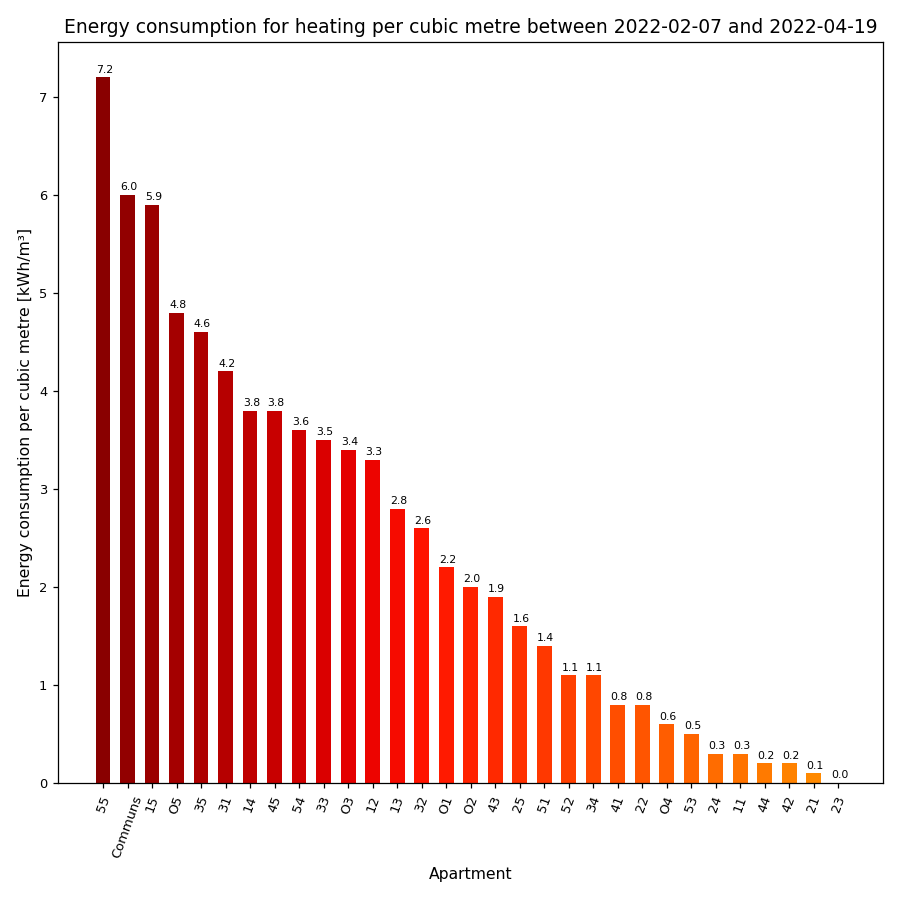

In [43]:
# Bar chart of energy consumption for heating per cubic metre for each apartment
# Checking if there is energy consumption during the time period before proceeding with the plot

if max(data_E)>0:
    
    # Ordering the data of "df_E" by descending value of energy consumption per cubic metre
    # Storing in variable "h" a small height defined in terms of df_E
    
    df_E_bis = df_E.sort_values('\u0394E per m\u00b3 [kWh/m\u00b3]', ascending=False)
    h_E = max(df_E_bis['\u0394E per m\u00b3 [kWh/m\u00b3]']) / 150

    # Parameters, title and annotations of the bar plot

    _, ECM = plt.subplots(figsize=(8, 8))
    ECM.set_title('Energy consumption for heating per cubic metre between %s and %s' % (eval(start), eval(end)))
    
    colors = plt.colormaps['jet_r'](range(2,64,2))
    ECM.set_ylabel('Energy consumption per cubic metre [kWh/m\u00b3]')
    ECM.set_xlabel('Apartment')
    plt.xticks(rotation=70)
    
    fig = ECM.bar(df_E_bis['apartment'], df_E_bis['\u0394E per m\u00b3 [kWh/m\u00b3]'], color=colors, width=0.6)
    
    for bar in fig:
        plt.annotate(bar.get_height(), xy=(bar.get_x(), bar.get_height() + h_E), size='x-small')

    plt.rcParams['xtick.labelsize'] = 'small'
    plt.rcParams['ytick.labelsize'] = 'small'    
    plt.tight_layout()

else:
    print('Nothing to plot: no energy consumption between %s and %s' % (eval(start), eval(end)))

# Temperatures

In this part of the analysis, we compare the temperatures measured and the temperatures set in each apartment of the building, over the period of time between "start" and "end".

In [44]:
dflist_get, dflist_set = [], []

for apartment in apartments:
    
    # Storing in "temp_get" the daily average of measured temperature (get) between "start" and "end"
    # Done for each apartment of the building
    
    temp_get = pd.read_sql('SELECT DATE(Temperatures.date) AS date, \
                       ROUND(AVG(Temperatures.value),2) AS \'#%s (get)\' \
                       FROM Temperatures INNER JOIN Apartments ON Temperatures.apartment_id=Apartments.esmart_id \
                       WHERE Apartments.name=\'%s\' AND Temperatures.action="get" \
                       AND Temperatures.date>=%s AND Temperatures.date<=%s \
                       AND TIME(Temperatures.date) BETWEEN "00:00:00" AND "23:59:59" \
                       GROUP BY DATE(Temperatures.date)' % (apartment, apartment, start, end), engine)
    
    # Storing in "temp_set" the daily average of set temperature (set) between "start" and "end"
    # Done for each apartment of the building
    
    temp_set = pd.read_sql('SELECT DATE(Temperatures.date) AS date, \
                       ROUND(AVG(Temperatures.value),2) AS \'#%s (set)\' \
                       FROM Temperatures INNER JOIN Apartments ON Temperatures.apartment_id=Apartments.esmart_id \
                       WHERE Apartments.name=\'%s\' AND Temperatures.action="set" \
                       AND Temperatures.date>=%s AND Temperatures.date<=%s \
                       AND TIME(Temperatures.date) BETWEEN "00:00:00" AND "23:59:59" \
                       GROUP BY DATE(Temperatures.date)' % (apartment, apartment, start, end), engine)
    
    # Collecting the DataFrames "temp_get" and "temp_set" in the lists "dflist_get" and "dflist_set"
    
    dflist_get.append(temp_get)
    dflist_set.append(temp_set)

In [45]:
# Importing the function "reduce" from library "functools" to merge lists of DataFrames

from functools import reduce

# Merging the DataFrames in "dflist_get" into a single DataFrame "merge_get"
# Making a copy of it in DataFrame "df_get"

merge_get = reduce(lambda x, y: pd.merge(x, y, on='date', how='outer'), dflist_get)
df_get = merge_get.copy(deep=True)

# Computing for each day the weighted average of the temperatures measured in each apartment
# The weights are the volumes of the apartments (the larger the volume, the larger the weight)
# See https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Mathematical_definition
# Using a masked array (from the numpy.ma module) to discard "NaN" values

masked_get = np.ma.masked_array(merge_get.drop('date', axis=1), np.isnan(merge_get.drop('date', axis=1)))
df_get['average (get)'] = np.ma.average(masked_get, axis=1, weights=volumes)

# Computing for each day the min and max temperatures measured in the apartments
# The original (unmodified) DataFrame "merge_get" is used for the computations
# Rounding to one decimal the values of the resulting DataFrame

df_get['min (get)'] = (merge_get.drop('date', axis=1)).min(axis=1)
df_get['max (get)'] = (merge_get.drop('date', axis=1)).max(axis=1)
df_get = round(df_get, 1)

# Merging the DataFrames in "dflist_set" into a single DataFrame "merge_set"
# Making a copy of it in DataFrame "df_set"

merge_set = reduce(lambda x, y: pd.merge(x, y, on='date', how='outer'), dflist_set)
df_set = merge_set.copy(deep=True)

# Computing for each day the usual average of the temperatures set in each apartment
# Using a masked array (from the numpy.ma module) to discard "NaN" values

masked_set = np.ma.masked_array(merge_set.drop('date', axis=1), np.isnan(merge_set.drop('date', axis=1)))
df_set['average (set)'] = np.ma.average(masked_set, axis=1)

# Computing for each day the min and max temperatures set in the apartments
# The original (unmodified) DataFrame "merge_set" is used for the computations
# Rounding to one decimal the values of the resulting DataFrame

df_set['min (set)'] = (merge_set.drop('date', axis=1)).min(axis=1)
df_set['max (set)'] = (merge_set.drop('date', axis=1)).max(axis=1)
df_set = round(df_set, 1)

df_get.head()

,date,#11 (get),#12 (get),#13 (get),#14 (get),#15 (get),#21 (get),#22 (get),#23 (get),#24 (get),...,#55 (get),#Communs (get),#O1 (get),#O2 (get),#O3 (get),#O4 (get),#O5 (get),average (get),min (get),max (get)
0,2022-02-07,21.7,22.1,22.5,22.4,22.1,21.1,22.6,21.9,21.2,...,21.7,21.0,20.3,21.2,20.9,21.8,23.4,21.6,20.0,23.4
1,2022-02-08,21.4,22.2,22.2,22.5,21.0,21.0,22.6,21.7,21.3,...,21.8,21.0,20.4,21.4,20.8,21.8,23.2,21.6,20.4,23.2
2,2022-02-09,21.4,22.3,22.2,22.4,22.0,21.0,22.7,21.8,21.2,...,21.9,21.0,20.4,21.4,21.1,21.8,23.2,21.6,20.4,23.2
3,2022-02-10,21.5,22.6,22.2,22.6,22.2,21.2,23.2,22.0,21.4,...,22.1,21.1,20.3,21.6,21.5,21.8,23.2,21.8,20.3,23.2
4,2022-02-11,21.4,22.7,22.2,22.5,22.3,21.2,23.0,22.3,21.5,...,22.2,20.9,20.3,21.4,21.5,21.8,23.3,21.8,20.3,23.3


<IPython.core.display.Javascript object>


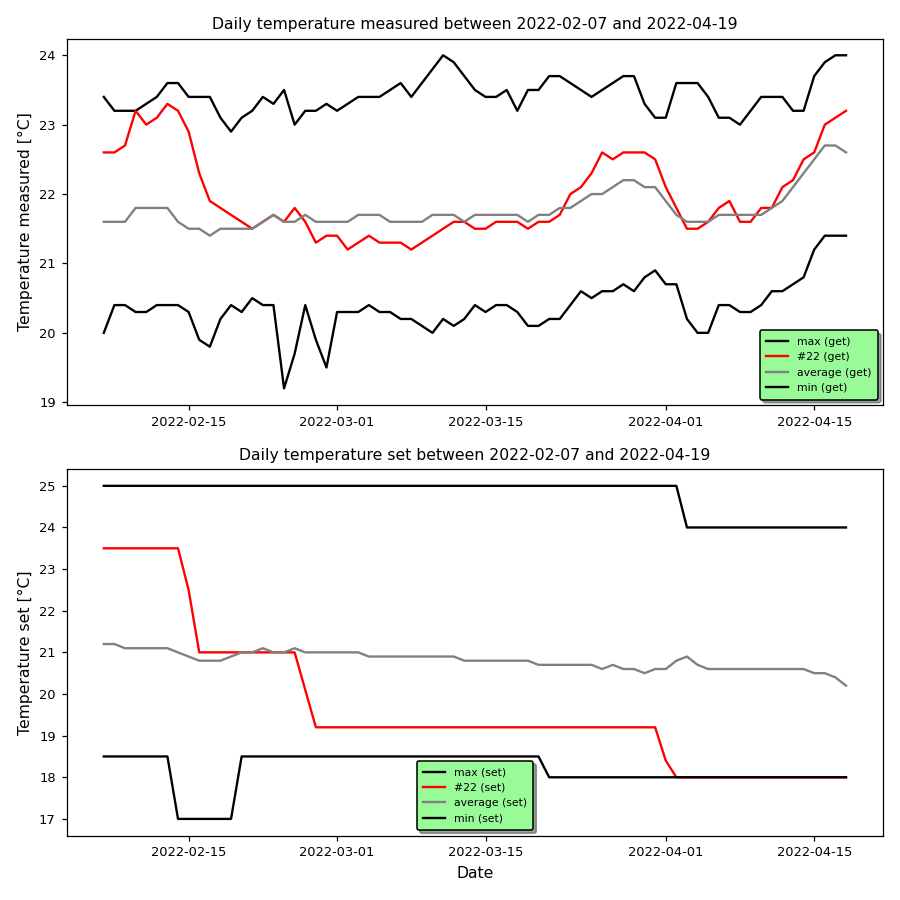

In [46]:
# Plot of the graphs of the temperatures measured (get) and set (set) for a given apartment
# In each figure, the min, max and average temperatures of the 31 apartments are plotted too

apartment = '22'

# Parameters, title, legends and annotations of the two graphs "g1" and "g2"

_, (g1, g2) = plt.subplots(2, figsize=(8, 8))

g1.plot(df_get['date'], df_get['max (get)'], color='k', label='max (get)')
g1.plot(df_get['date'], df_get['#%s (get)'% apartment], color='r', label='#%s (get)' % apartment)
g1.plot(df_get['date'], df_get['average (get)'], color='grey', label='average (get)')
g1.plot(df_get['date'], df_get['min (get)'], color='k', label='min (get)')

g1.set_title('Daily temperature measured between %s and %s' % (eval(start), eval(end)), size='medium')
g1.legend(fontsize='x-small', borderpad=0.6, shadow=True, facecolor='palegreen', edgecolor='k')
g1.set_ylabel('Temperature measured [°C]')

g2.plot(df_set['date'], df_set['max (set)'], color='k', label='max (set)')
g2.plot(df_set['date'], df_set['#%s (set)'% apartment], color='r', label='#%s (set)' % apartment)
g2.plot(df_set['date'], df_set['average (set)'], color='grey', label='average (set)')
g2.plot(df_set['date'], df_set['min (set)'], color='k', label='min (set)')

g2.set_title('Daily temperature set between %s and %s' % (eval(start), eval(end)), size='medium')
g2.legend(fontsize='x-small', borderpad=0.6, shadow=True, facecolor='palegreen', edgecolor='k')
g2.set_ylabel('Temperature set [°C]')
g2.set_xlabel('Date')

plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'
plt.tight_layout()

# Energy consumption vs. temperatures

In the last part of the analysis, we link the energy consumption to the temperatures (measured and set) in the apartments. For that purpose, we compute mean signed deviations (MSD) of these quantities from their average.

Mean signed deviations provide a signed measure of the distance of a given data from an estimated value of that data.<br>
https://en.wikipedia.org/wiki/Mean_signed_deviation

In [47]:
# Computing MSD of measured temperature, MSD of set temperature and MSD of energy consumption per cubic metre

df_dev = pd.DataFrame()

# Storing in "df_dev" the deviations from the average temperature (get and set) for each apartment

for x in apartments:
    df_dev['#%s deviation (get)'% x] = df_get['#%s (get)'% x] - df_get['average (get)']
    df_dev['#%s deviation (set)'% x] = df_set['#%s (set)'% x] - df_set['average (set)']

df_MSD = pd.DataFrame()
df_MSD['apartment'] = apartments

# Using masked arrays (from the numpy.ma module) to discard "NaN" values when computing MSD of temperatures

masked_get = np.ma.masked_array(df_dev.iloc[:, ::2], np.isnan(df_dev.iloc[:, ::2]))
df_MSD['MSD (get)'] = np.ma.average(masked_get, axis=0)

masked_set = np.ma.masked_array(df_dev.iloc[:, 1::2], np.isnan(df_dev.iloc[:, 1::2]))
df_MSD['MSD (set)'] = np.ma.average(masked_set, axis=0)

# Storing in "df_MSD" the MSD of energy consumption per cubic metre

average_E_cubic = np.average(df_E['\u0394E per m\u00b3 [kWh/m\u00b3]'])
df_MSD['MSD (\u0394E per m\u00b3)'] = df_E['\u0394E per m\u00b3 [kWh/m\u00b3]'] - average_E_cubic

# Rounding to two decimals the values of "df_MSD" and setting the column "apartment" as index column

df_MSD = round(df_MSD, 2)
df_MSD.index = [''] * len(df_MSD)
df_MSD.head()

,apartment,MSD (get),MSD (set),MSD (ΔE per m³)
,11,-0.10,-1.26,-2.11
,12,0.37,0.39,0.89
,13,0.41,0.38,0.39
,14,0.67,1.35,1.39
,15,0.46,3.54,3.49


First, we plot the MSD of measured temperatures vs. the MSD of set temperatures.

We use a color palette to plot in red the apartments with large MSD of measured temperature (temperature larger than the average) and blue the apartments with small MSD of measured temperature (temperature smaller than the average).

<IPython.core.display.Javascript object>


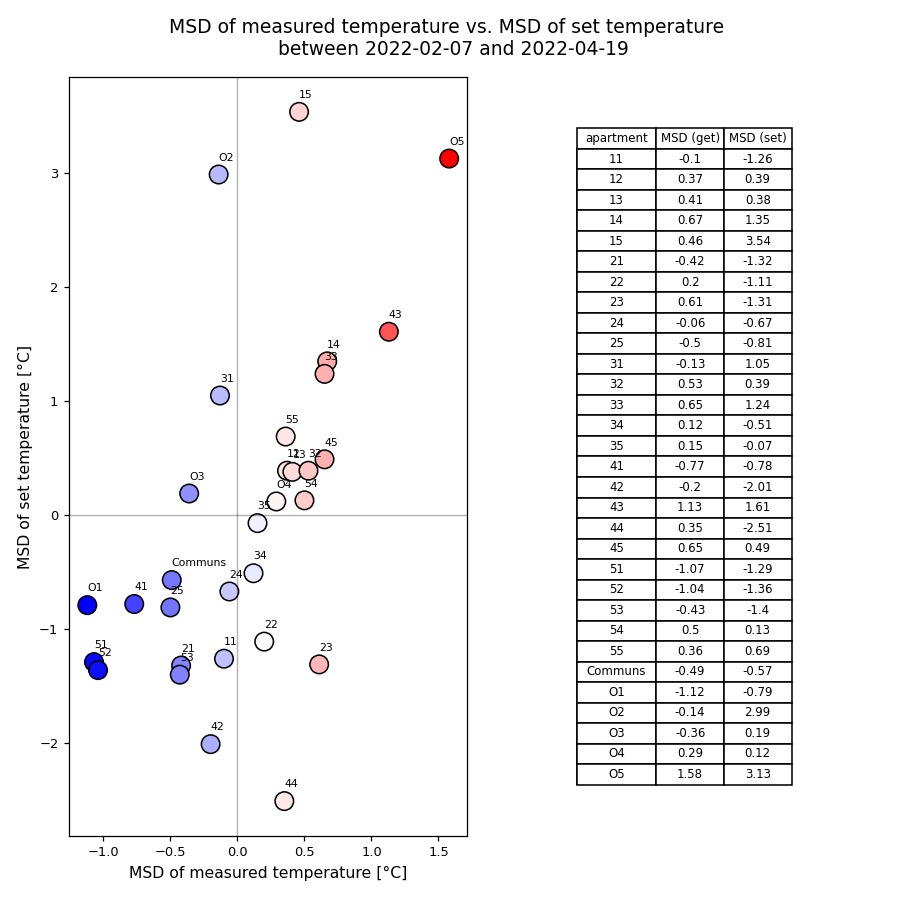

In [48]:
# Importing the "table" function from "pandas.plotting" toolkit to plot DataFrames

from pandas.plotting import table

# Parameters, title, legends and annotations of the scatter plot "p1" and the table "p2"

_, (p1, p2) = plt.subplots(1,2, figsize=(8, 8))
plt.suptitle('MSD of measured temperature vs. MSD of set temperature \n between %s and %s'
             % (eval(start), eval(end)))

data_get = df_MSD['MSD (get)']
data_set = df_MSD['MSD (set)']
h_set = (max(data_set) - min(data_set)) / 50
values = [(data_get[i] - min(data_get)) / (max(data_get) - min(data_get)) for i in range(len(data_get))]
colors = plt.colormaps['bwr'](values)

p1.scatter(data_get, data_set, s=140, c=colors, edgecolors='k')
p1.set_xlabel('MSD of measured temperature [°C]')
p1.set_ylabel('MSD of set temperature [°C]')
p1.axvline(color='k', lw=0.9, alpha=0.3)
p1.axhline(color='k', lw=0.9, alpha=0.3)

for apartment, x, y in zip(apartments, data_get, data_set):
    p1.text(x, y + h_set, apartment, size='x-small')

p2.axis('tight')
p2.axis('off')
the_table = table(p2, df_MSD[['apartment', 'MSD (get)', 'MSD (set)']],
                  loc='center', colWidths=[0.2, 0.17, 0.17], cellLoc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(7.5)

plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'
plt.tight_layout()

The MSD of measured temperatures seems to be a growing function of the MSD of set temperatures (the upper-right and the bottom-down quadrants of the scatter plot are more populated). This means, as intuition suggests, that if a user sets at a high temperature on the thermostats of an apartment, then one ends up with a high temperature in that apartment.

However, this is too simplistic because the set temperatures of an apartment may have no relevance at all, as for instance when the apartment presents no energy consumption during the period considered. In that situation, the heating system could be disabled, not working, or other.

We thus plot in a second figure the MSD of measured temperatures vs. MSD of energy consumption per cubic metre, which are a priori more reliable data.

<IPython.core.display.Javascript object>


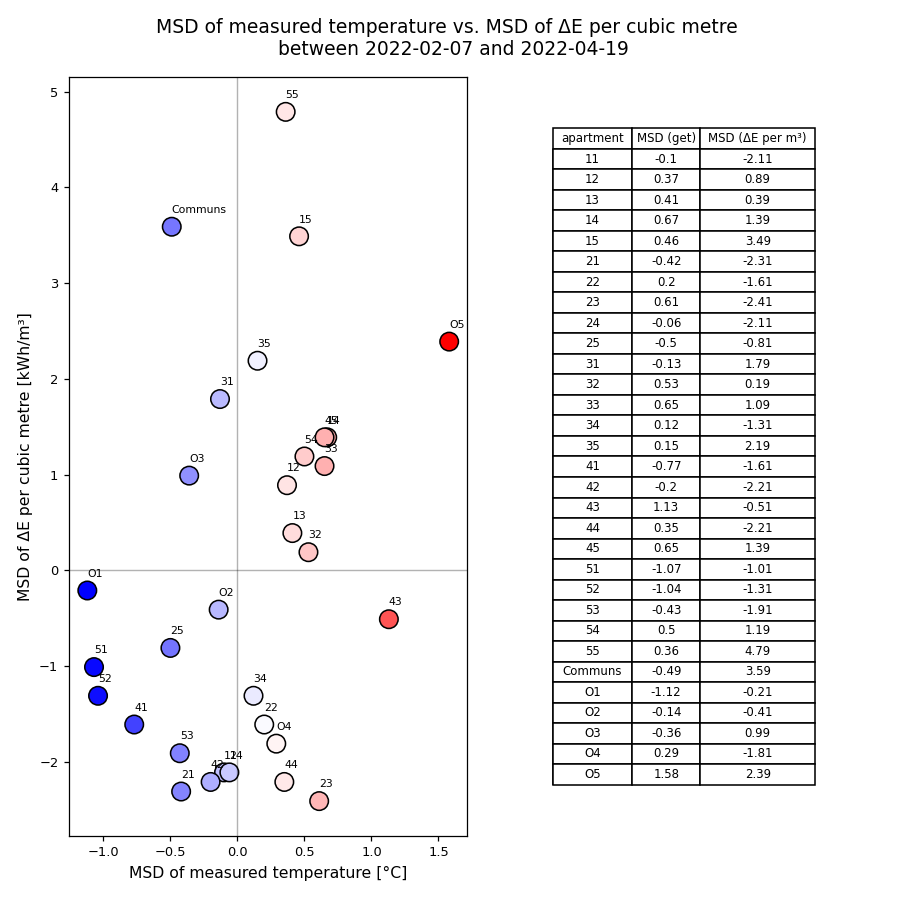

In [49]:
# Parameters, title, legends and annotations of the scatter plot "p3" and the table "p4"

_, (p3, p4) = plt.subplots(1,2, figsize=(8, 8))
plt.suptitle('MSD of measured temperature vs. MSD of \u0394E per cubic metre \n between %s and %s'
             % (eval(start), eval(end)))

data_cubic = df_MSD['MSD (\u0394E per m\u00b3)']
h_cubic = (max(data_cubic) - min(data_cubic)) / 50

p3.scatter(data_get, data_cubic, s=140, c=colors, edgecolors='k')
p3.set_ylabel('MSD of \u0394E per cubic metre [kWh/m\u00b3]')
p3.set_xlabel('MSD of measured temperature [°C]')
p3.axvline(color='k', lw=0.9, alpha=0.3)
p3.axhline(color='k', lw=0.9, alpha=0.3)

for apartment, x, y in zip(apartments, data_get, data_cubic):
    p3.text(x, y + h_cubic, apartment, size='x-small')

p4.axis('tight')
p4.axis('off')
the_table = table(p4, df_MSD[['apartment', 'MSD (get)', 'MSD (\u0394E per m\u00b3)']],
                  loc='center', colWidths=[0.2, 0.17, 0.29], cellLoc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(7.5)

plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'
plt.tight_layout()

Once again, in agreement with intuition, the MSD of measured temperature seems to be a growing function of the MSD of the energy consumption per cubic metre (the upper-right and the bottom-down quadrants of the scatter plot are more populated).

However, the precise function relating the two quantities is certainly complicated, depends on other variables and is not linear. Therefore, in order to locate possible outliers (apartments presenting an "eccentric" behaviour), we prefer to use a clustering algorithm. This doesn't require knowlege about the precise relations linking the data.

# Outliers

To locate the outliers, we use the DBSCAN clustering algorithm taken from the "sklearn.cluster" module of the "scikit-learn" machine learning library.
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
https://en.wikipedia.org/wiki/DBSCAN

<IPython.core.display.Javascript object>


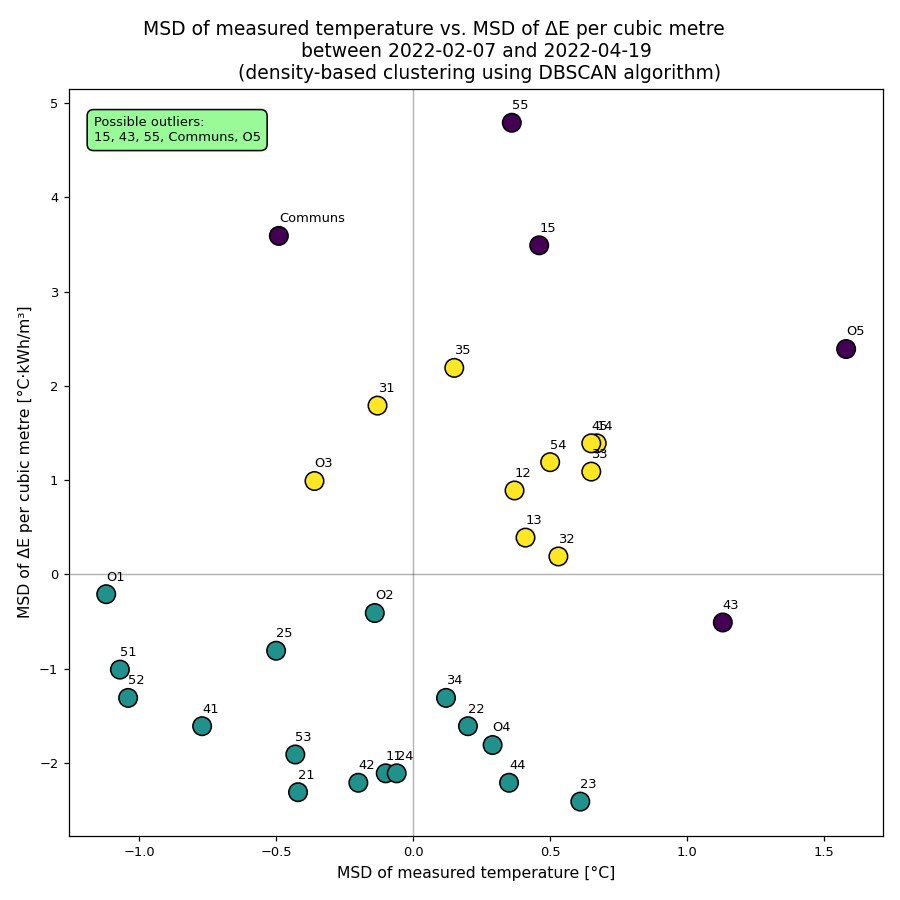

In [50]:
# Importing DBSCAN clustering algorithm from "sklearn.cluster" module

from sklearn.cluster import DBSCAN

# Storing the 2D data into numpy array "data_cluster"

data_cluster = df_MSD[['MSD (get)', 'MSD (\u0394E per m\u00b3)']].values

# Applying DBSCAN algorithm with radius "eps", cluster cardinal "min_samples" and Euclidean "metric"
# Storing in a string "outliers" the outliers provided by the algorithm

model = DBSCAN(eps=0.9, min_samples=5, metric='euclidean').fit(data_cluster)
labels = model.labels_
outliers = ', '.join([apartments[i] for i in range(len(labels)) if labels[i] == -1])

# Plotting the clusters found by the DBSCAN algorithm as a scatter plot "p5"
# Setting the parameters, title and annotations of the scatter plot

_, p5 = plt.subplots(figsize=(8, 8))

p5.scatter(data_get, data_cubic, s=140, c=labels, edgecolors='k')

p5.set_title('MSD of measured temperature vs. MSD of \u0394E per cubic metre \
             \n between %s and %s \n (density-based clustering using DBSCAN algorithm)'
             % (eval(start), eval(end)))

p5.set_ylabel('MSD of \u0394E per cubic metre [°C⋅kWh/m\u00b3]')
p5.set_xlabel('MSD of measured temperature [°C]')
p5.axvline(color='k', lw=0.9, alpha=0.3)
p5.axhline(color='k', lw=0.9, alpha=0.3)

p5.annotate('Possible outliers:\n%s' % outliers, xy=(0.03, 0.93), xycoords='axes fraction',
            bbox=dict(fc='palegreen', boxstyle='round,pad=0.5'), size='small')

for apartment, x, y in zip(apartments, data_get, data_cubic):
    p5.text(x, y + h_cubic, apartment, size='small')

plt.tight_layout()